In [1]:
import pandas as pd
import logging
import json
from itertools import product
from datetime import datetime, timedelta

pd.set_option("display.float_format", "{:.2f}".format)

In [2]:
# Functions

def get_logger() -> logging.Logger:
    """
    Get logger instance.
    """
    level = logging.INFO
    logger = logging.getLogger(__name__)
    logger.setLevel(level)
    logger.propagate = False
    logger.handlers = []
    console_handler = logging.StreamHandler()
    console_handler.setLevel(level)
    formatter = logging.Formatter(
        "%(asctime)s %(levelname)s | %(message)s", "%Y-%m-%d %H:%M:%S"
    )
    console_handler.setFormatter(formatter)
    logger.addHandler(console_handler)

    return logger

def json_expansion(df, payload_column):
  expanded_list = []
  os_multiplier = []
  for idx, row in df[payload_column].items():
    row_update = json.loads(row)['allocations']
    row_os_multiplier = json.loads(row)['os_multiplier']

    expanded = pd.json_normalize(row_update)
    expanded['original_index'] = idx
    expanded['os_multiplier'] = row_os_multiplier

    expanded_list.append(expanded)

  return expanded_list

def cap_and_normalise(df, column):
  total_allocation = df[column].sum()
  adjusted_allocation = 1
  capped_list = []

  for index, row in df.iterrows():
      capped_allocation = min((row[column] * adjusted_allocation)/total_allocation, 0.05)
      total_allocation = total_allocation  - row[column]
      adjusted_allocation = adjusted_allocation - capped_allocation
      capped_list.append(capped_allocation*10000000)

  return capped_list

In [3]:
# Data ingestion

ballot_df = pd.read_csv("Voting data export final.csv")
badgeholders_df = pd.read_csv("RPGF4_badgeholders.csv")
project_metrics_df = pd.read_csv("op_rf4_impact_metrics_by_project (1).csv")

In [28]:
project_metrics_df.head(10)

,project_name,application_id,is_oss,gas_fees,transaction_count,trusted_transaction_count,trusted_transaction_share,trusted_users_onboarded,daily_active_addresses,trusted_daily_active_users,monthly_active_addresses,trusted_monthly_active_users,recurring_addresses,trusted_recurring_users,power_user_addresses,openrank_trusted_users_count,log_gas_fees,log_transaction_count,log_trusted_transaction_count
0,Aave,0x3061b642db56c507e265f03029735b0413a613bda434...,True,10.35,622906.00,57100.00,0.09,831.00,1263.37,126.94,24398.15,2339.88,10650.00,1777.00,24816.00,230.00,1.06,5.79,4.76
1,Alchemix,0x12d482385e2c26d37da1f30c513d66c1fa39e9ed4980...,True,0.03,4523.00,492.00,0.11,3.00,10.00,1.24,206.30,27.41,103.00,13.00,599.00,10.00,0.01,3.66,2.69
2,Biconomy,0x220685a4514003f22cbf18a7ddd9c09f88c2383daed6...,False,0.68,3668646.00,103.00,0.00,4.00,896.42,0.34,3634.44,8.64,386.00,3.00,109.00,4.00,0.23,6.56,2.02
3,0x Protocol,0x0fad18f37ecec4f4f4ca18e60c353eb11462363e8aa1...,True,75.07,1739387.00,88370.00,0.05,2260.00,3728.64,240.34,67667.78,3766.42,31404.00,3502.00,24012.00,1094.00,1.88,6.24,4.95
4,CreateMyToken,0xdf3eb6b429b2150c71241de0c591b18c98a3528ad0e8...,False,0.00,3.00,0.00,0.00,0.00,0.01,0.00,0.37,0.00,0.00,0.00,0.00,0.00,0.00,0.60,0.00
5,Poster,0x8a0f263d8dca18ceca0615836a5401c9dd31c7141ee4...,True,0.00,40.00,0.00,0.00,0.00,0.00,0.00,0.12,0.00,0.00,0.00,0.00,0.00,0.00,1.61,0.00
6,Loot2,0x7fd77f963d3383d7aa4dd67652c6554ce6f0661aad01...,True,0.33,75928.00,5793.00,0.08,20.00,244.58,20.16,4734.94,290.74,713.00,0.00,7279.00,46.00,0.12,4.88,3.76
7,Wombat Exchange,0x1d585df770de05257717b33075f6d32e79fb60ec507c...,False,0.20,16282.00,2019.00,0.12,10.00,17.84,2.24,312.96,43.21,78.00,9.00,682.00,5.00,0.08,4.21,3.31
8,Ethereum Attestation Service (EAS),0xa88844cea135382e3484e39c3172033437121b35ca0b...,True,4.81,89280.00,10664.00,0.12,119.00,88.63,28.38,1967.78,630.62,108.00,65.00,6163.00,268.00,0.76,4.95,4.03
9,Wormhole Foundation,0x35e2308213d675d5c25463a80fd318c2ae2478f47c4f...,False,2.61,245136.00,18815.00,0.08,518.00,366.26,43.25,8641.98,989.26,1166.00,286.00,12977.00,108.00,0.56,5.39,4.27


In [29]:
badgeholders_df.head()

,Badgeholder,Unnamed: 1
0,0xEee718c1e522ecB4b609265db7A83Ab48ea0B06f,NaN
1,0x7899d9b1181cbB427b0b1BE0684C096C260F7474,NaN
2,0x66Da63B03feCA7Dd44a5bB023BB3645D3252Fa32,NaN
3,0x1de2A056508E0D0dd88A88f1f5cdf9cfa510795c,NaN
4,0x98Ab20307fdABa1ce8b16d69d22461c6dbe85459,NaN


In [31]:
ballot_df.head(10)

,Address,Badgeholder,Status,Created at,Updated at,Published at,Metrics in ballot,Metrics viewed,Os multiplier,Ballot content,Signature,Payload
0,0x55aed0ce035883626e536254dda2f23a5b5d977f,True,SUBMITTED,2024-06-30T16:59:46.549Z,2024-07-02T09:27:37.745Z,2024-07-02T09:27:37.745Z,16,8,1.80,"[{""trusted_daily_active_users"":2},{""trusted_mo...",0x79e26338bf41c0cb4ac15030f1fb6eb932ade1e33e4a...,"{""allocations"":[{""trusted_daily_active_users"":..."
1,0x3b60e31cfc48a9074cd5bebb26c9eaa77650a43f,True,SUBMITTED,2024-06-29T15:44:59.942Z,2024-06-29T15:45:57.977Z,2024-06-29T15:45:57.977Z,7,16,1.00,"[{""trusted_users_onboarded"":20},{""trusted_recu...",0x9841ba7d0cfbc7933ef05bef58c49423ba26169fa665...,"{""allocations"":[{""trusted_users_onboarded"":20}..."
2,0x512fce9b07ce64590849115ee6b32fd40ec0f5f3,True,SUBMITTED,2024-07-03T15:47:12.813Z,2024-07-03T15:47:55.494Z,2024-07-03T15:47:55.494Z,4,0,1.00,"[{""gas_fees"":25.002499750025},{""log_transactio...",0x7f54abc8dcd3711d71e0e592a9d34662a985a53b6acf...,"{""allocations"":[{""gas_fees"":25.002499750025},{..."
3,0xd8da6bf26964af9d7eed9e03e53415d37aa96045,True,SUBMITTED,2024-07-11T12:29:41.116Z,2024-07-11T12:30:08.007Z,2024-07-11T12:30:08.007Z,3,0,1.00,"[{""openrank_trusted_users_count"":33.335},{""tru...",0xd99fb446d6e109733d937dc661240c3ad13dfa75732d...,"{""allocations"":[{""openrank_trusted_users_count..."
4,0x616cad18642f45d3fa5fcaad0a2d81764a9cba84,True,SUBMITTED,2024-06-29T01:50:57.995Z,2024-07-10T22:07:39.974Z,2024-07-10T22:07:39.974Z,4,16,3.00,"[{""trusted_recurring_users"":40},{""transaction_...",0x04e7634d51800b606e21615c8cb23086b9e2c49c22d4...,"{""allocations"":[{""trusted_recurring_users"":40}..."
5,0x1f5d295778796a8b9f29600a585ab73d452acb1c,True,SUBMITTED,2024-06-30T08:56:32.275Z,2024-06-30T09:14:57.016Z,2024-06-30T09:14:57.016Z,6,1,3.00,"[{""log_gas_fees"":16},{""trusted_recurring_users...",0x856860c8bd407f2b301aa995c8130dee697616628241...,"{""allocations"":[{""log_gas_fees"":16},{""trusted_..."
6,0x146cfed833cc926b16b0da9257e8a281c2add9f3,True,SUBMITTED,2024-07-11T10:29:25.861Z,2024-07-11T10:30:21.457Z,2024-07-11T10:30:21.457Z,3,3,3.00,"[{""trusted_transaction_count"":33.335},{""openra...",0xa3f8ce3b2d2424c10891d51f925c7d493e1b88ae359d...,"{""allocations"":[{""trusted_transaction_count"":3..."
7,0x07fda67513ec0897866098a11dc3858089d4a505,True,SUBMITTED,2024-07-09T07:37:57.355Z,2024-07-09T08:43:40.365Z,2024-07-09T08:43:40.365Z,4,3,1.50,"[{""log_gas_fees"":50},{""monthly_active_addresse...",0xa29ffb356b775fc9a49813e15ff81755b9f8e71d4340...,"{""allocations"":[{""log_gas_fees"":50},{""monthly_..."
8,0x69e271483c38ed4902a55c3ea8aab9e7cc8617e5,True,SUBMITTED,2024-06-28T13:25:48.734Z,2024-07-10T14:35:56.755Z,2024-07-10T14:35:56.755Z,2,12,3.00,"[{""log_transaction_count"":50},{""log_gas_fees"":...",0xf24c4fd39776581ae8d50b6e629dd30df645721a36d0...,"{""allocations"":[{""log_transaction_count"":50},{..."
9,0x5d36a202687fd6bd0f670545334bf0b4827cc1e2,True,SUBMITTED,2024-07-08T06:33:36.164Z,2024-07-11T16:03:06.890Z,2024-07-11T16:03:06.890Z,4,9,2.30,"[{""gas_fees"":56},{""power_user_addresses"":14},{...",0x5c45bfeef1957cc827477b477c918b5c679caebf7a81...,"{""allocations"":[{""gas_fees"":56},{""power_user_a..."


In [4]:
# Vote and voter validation

log = get_logger()

# Check if voter_address is unique
if ballot_df["Address"].nunique() == ballot_df.shape[0]:
    log.info("Check - Address is unique.")
else:
    diff = ballot_df.shape[0] - ballot_df["Address"].nunique()
    log.info(f"Check - Address is not unique. There are {diff} duplicates.")

# Check if all address in df are in df_badge_holders
voter_validity_check = ballot_df["Address"].str.lower().isin(badgeholders_df["Badgeholder"].str.lower())

if ballot_df[voter_validity_check].shape[0] == ballot_df.shape[0]:
    log.info("Check - All addresses in df are in df_badge_holders.")
else:
    diff = ballot_df.shape[0] - ballot_df[voter_validity_check].shape[0]
    log.info(f"Check - {diff} addresses in voting are not Badge Holders.")
    # print those addresses not in df_badge_holders
    display(ballot_df[voter_validity_check])

# Check if all ballots have a signature
ballot_bh_df = ballot_df[voter_validity_check]
signature_filtered_df = ballot_bh_df[ballot_bh_df['Signature'].notna()]

2024-09-10 21:00:13 INFO | Check - Address is unique.
2024-09-10 21:00:13 INFO | Check - All addresses in df are in df_badge_holders.


In [5]:
expanded_list = json_expansion(signature_filtered_df, 'Payload')
expanded_df = pd.concat(expanded_list, ignore_index=True)

result_df = expanded_df.set_index("original_index").join(ballot_df.set_index(ballot_df.index))

# Define the columns and aggregations
sum_cols = list(expanded_df.columns)
sum_cols.remove('os_multiplier')
sum_cols.remove("original_index")

unique_cols = list(ballot_df.columns) + ['os_multiplier']

# Define the aggregations
aggregations = {
    col: 'sum' for col in sum_cols
}
aggregations.update({
    col: lambda x: x.iloc[0] for col in unique_cols
})

# Group by index and use agg() to combine the values
grouped_result = result_df.groupby(result_df.index).agg(aggregations)
grouped_result['metric_total'] = grouped_result[sum_cols].sum(axis=1)

In [6]:
# Generate ImpactMetricShares by Project and Badgeholder

bh_subset = signature_filtered_df[['Address', 'Payload']]

expanded_list = []
expanded_index = []
for idx, row in bh_subset["Payload"].items():

  row_update = json.loads(row)['os_multiplier']
  expanded_list.append(row_update)
  expanded_index.append(idx)

multiplier_expanded = pd.DataFrame(
    {'original_index': expanded_index,
     'os_multiplier': expanded_list
    })

bh_subset = multiplier_expanded.set_index("original_index").join(bh_subset.set_index(bh_subset.index))

# Create a list of all possible combinations of indices
indices = list(product(project_metrics_df.index, bh_subset.index))

# Create a DataFrame with the combined indices
combined_df = pd.DataFrame(indices, columns=['index1', 'index2'])

# Perform the join using merge()
metric_sum_df = pd.merge(combined_df, project_metrics_df, left_on='index1', right_index=True) \
          .merge(bh_subset, left_on='index2', right_index=True)

for col in sum_cols:
    metric_sum_df.loc[metric_sum_df['is_oss'] == True, col] = \
    metric_sum_df.loc[metric_sum_df['is_oss'] == True, col] * metric_sum_df.loc[metric_sum_df['is_oss'] == True, 'os_multiplier']

for address in bh_subset['Address']:
    for col in sum_cols:
        metric_sum_df.loc[metric_sum_df['Address'] == address, col] = \
        metric_sum_df.loc[metric_sum_df['Address'] == address, col] / metric_sum_df.loc[metric_sum_df['Address'] == address, col].sum()

In [7]:
# Generate the Score by Badgeholder

badgeholder_allocation_df = metric_sum_df.copy()

for address in bh_subset['Address']:

    for col in sum_cols:
        if grouped_result.loc[grouped_result['Address'] == address, col].iloc[0] == 0:
          badgeholder_allocation_df.loc[badgeholder_allocation_df['Address'] == address, col] = badgeholder_allocation_df.loc[badgeholder_allocation_df['Address'] == address, col]* 0
        else:
          badgeholder_allocation_df.loc[badgeholder_allocation_df['Address'] == address, col] = badgeholder_allocation_df.loc[badgeholder_allocation_df['Address'] == address, col]* (grouped_result.loc[grouped_result['Address'] == address, col].iloc[0]/100)

# Calculate badgeholder score for each project
badgeholder_allocation_df['badgeholder_allocation'] = badgeholder_allocation_df[sum_cols].sum(axis=1)

In [15]:
badgeholder_allocation_df.to_csv("badgeholder_allocation_data.csv", encoding='utf-8')
badgeholder_allocation_df.head()

,index1,index2,project_name,application_id,is_oss,gas_fees,transaction_count,trusted_transaction_count,trusted_transaction_share,trusted_users_onboarded,...,trusted_recurring_users,power_user_addresses,openrank_trusted_users_count,log_gas_fees,log_transaction_count,log_trusted_transaction_count,os_multiplier,Address,Payload,badgeholder_allocation
0,0,0,Aave,0x3061b642db56c507e265f03029735b0413a613bda434...,True,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,1.80,0x55aed0ce035883626e536254dda2f23a5b5d977f,"{""allocations"":[{""trusted_daily_active_users"":...",0.01
1,0,1,Aave,0x3061b642db56c507e265f03029735b0413a613bda434...,True,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0x3b60e31cfc48a9074cd5bebb26c9eaa77650a43f,"{""allocations"":[{""trusted_users_onboarded"":20}...",0.01
2,0,2,Aave,0x3061b642db56c507e265f03029735b0413a613bda434...,True,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0x512fce9b07ce64590849115ee6b32fd40ec0f5f3,"{""allocations"":[{""gas_fees"":25.002499750025},{...",0.01
3,0,3,Aave,0x3061b642db56c507e265f03029735b0413a613bda434...,True,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0xd8da6bf26964af9d7eed9e03e53415d37aa96045,"{""allocations"":[{""openrank_trusted_users_count...",0.01
4,0,4,Aave,0x3061b642db56c507e265f03029735b0413a613bda434...,True,0.00,0.00,0.00,0.00,0.00,...,0.01,0.00,0.00,0.00,0.00,0.00,3.00,0x616cad18642f45d3fa5fcaad0a2d81764a9cba84,"{""allocations"":[{""trusted_recurring_users"":40}...",0.01


In [70]:
median_score_df = badgeholder_allocation_df.copy()

updated_median_df = pd.DataFrame()
capped_list = []

for address in bh_subset['Address']:
  df = median_score_df.loc[median_score_df['Address'] == address].sort_values(by ='badgeholder_allocation', ascending=False)
  updated_median_df = pd.concat([updated_median_df, df], ignore_index=True)

  # Normalise and re-cap score values
  if not capped_list:
    capped_list = cap_and_normalise(df,'badgeholder_allocation')
  else:
    capped_list = capped_list + cap_and_normalise(df,'badgeholder_allocation')

updated_median_df['badgeholder_score'] = capped_list
median_scores = updated_median_df.groupby(['project_name','application_id']).agg(median_score=('badgeholder_score', 'median'))
median_scores  

,,median_score
project_name,application_id,
$ENJOY,0x3fd997714a3a9df6dce8a21992dcae361b34432d39b7fd7e04e52eaf0aeaa588,39536.08
/send,0x5614d129eba060ce7d224e8e8f9f29aeddfdb572b0dd45edc81f18f5307bc01a,1275.37
0x Protocol,0x0fad18f37ecec4f4f4ca18e60c353eb11462363e8aa14562b5d96af54108d106,319783.74
3DNS,0x08d4923c8047ec8856f54a1d6e0763d41eaced38e621b2f15284437918defe1f,5803.87
Aave,0x3061b642db56c507e265f03029735b0413a613bda43456a31e78128baeb18754,126344.27
...,...,...
sudoswap,0x73899e48df9f895ffbffc36d53ce970c1454c8eeb0700ed20f303bf936b6a0f5,16855.92
tanX - The World's Leading Institutional DEX,0xa8213245a57be579692ead3a2381364f5942a68afd17b41a3ec1079e50af1a26,10085.40
zkBob smart contract privacy wallet,0x61d2e05f988e678b240a7f00c5f722a5a69f06f085f4ff33199e835a46949469,2936.08


In [113]:
# Generate final allocation by applying cap and normalizing to 10M

# Normalise and re-cap score values
final_median_scores = median_scores.copy().sort_values(by ='median_score', ascending=False)
final_median_scores['adjusted_score'] = cap_and_normalise(final_median_scores, 'median_score')

# Filter out projects with a badgeholder_score of less than 1000
filtered_median_scores = final_median_scores[final_median_scores['adjusted_score'] > 1000].sort_values(by ='adjusted_score', ascending=False)
filtered_median_scores['final_score'] = cap_and_normalise(filtered_median_scores, 'adjusted_score')

# Round score columns to 1 decimal place
cols_to_round = ['median_score', 'adjusted_score', 'final_score']
for col in cols_to_round:
    filtered_median_scores[col] = filtered_median_scores[col].round(1).astype(object)

filtered_median_scores = filtered_median_scores.sort_values(by = 'final_score', ascending=False)
filtered_median_scores.to_csv("median_allocation_results.csv", encoding='utf-8')
filtered_median_scores

,,median_score,adjusted_score,final_score
project_name,application_id,,,
Zora,0x9102357674825ed224734387fbefbf41c16fe5d9764c2f7f3e897ad3325d3990,500000.00,500000.00,500000.00
Layer3,0x91a4420e2fcc8311e97dad480f201a8ce221f2cd64c2de77280cbcc6ce193752,500000.00,500000.00,500000.00
LI.FI,0x517eaa9c56951de89261f2d7830ea49aae92f2a903104a17d9c5c2edd4959806,440940.50,480922.70,481556.20
Stargate Finance,0x62e37e96aa6e1cbfb6bd24b97c4b8f1e12cc3fe35d5388d2f041c42a12b40745,390718.50,426146.80,426708.10
ODOS,0xd5b4c54b12bf86f6eb67fec81032809a16ff1c4b4c7f0d5898fc86367db86ca6,328804.50,358618.80,359091.20
...,...,...,...,...
IntentX,0x2ddf5b9dc64f873d6557b4f63de936cf278f8851deda857244a1be44d1a1e950,1155.60,1260.40,1262.00
Egg Wars: A Game on Base,0xa4d3729a488eeabcc3a59de70b760391db50e9bf488d5942e704089c58825c24,1140.40,1243.90,1245.50
BaseDoge,0x69e36f30f2a21afb2eb61156ca00f303434ba8868315abec3eb8780b812fe976,1067.40,1164.20,1165.70


# Caculating Allocation for Majortarian Phantoms Voting Rules


In [164]:
import numpy as np

def majoritarian_moving_phantoms(voting_matrix, total_op_tokens, num_voters):
    num_voters, num_projects = voting_matrix.shape

    def f_k(t, k, num_voters):
        if t <= k / (num_voters + 1):
            return 0
        elif t < (k + 1) / (num_voters + 1):
            return (num_voters + 1) * t - k
        else:
            return 1

    def median_with_phantoms(t_star, j):
        phantom_votes = [f_k(t_star, k, num_voters) for k in range(num_voters + 1)]
        real_votes = voting_matrix[:, j] / sum(voting_matrix[0])  # Normalize real votes
        return np.median(phantom_votes + list(real_votes))

    def find_t_star():
        low, high = 0.0, 1.0
        epsilon = 1e-9
        while high - low > epsilon:
            mid = (low + high) / 2
            if sum(median_with_phantoms(mid, j) for j in range(num_projects)) > 1:
                high = mid
            else:
                low = mid
        return low

    t_star = find_t_star()
    distribution = np.array([median_with_phantoms(t_star, j) for j in range(num_projects)])
    best_distribution = distribution * (total_op_tokens / np.sum(distribution))
    return best_distribution


In [166]:
import numpy as np

# Get the unique project names from the DataFrame
unique_projects = badgeholder_allocation_df['project_name'].unique()

# Initialize a dictionary to store project allocations
project_allocations = {}

# Loop through each project and extract the badgeholder allocations for that project
for project in unique_projects:
    # Filter the rows for the current project
    project_df = badgeholder_allocation_df[badgeholder_allocation_df['project_name'] == project]
    
    # Get the badgeholder allocations as an array for the current project
    badgeholder_allocation_array = project_df['badgeholder_allocation'].values
    
    # Store the array in the dictionary with the project name as the key
    project_allocations[project] = badgeholder_allocation_array

# Show the allocations for a few projects
#{project: project_allocations[project] for project in list(project_allocations.keys())[:5]}

project_allocations

{'Aave': array([0.01103361, 0.00621537, 0.00664466, 0.00900227, 0.01112565,
        0.01496595, 0.01158712, 0.01174669, 0.01200131, 0.01004417,
        0.01320536, 0.00730713, 0.00590384, 0.01324923, 0.01400504,
        0.00867793, 0.01512268, 0.01043554, 0.01510494, 0.0137355 ,
        0.01050167, 0.00870668, 0.01450319, 0.00930661, 0.00488379,
        0.0115668 , 0.01285991, 0.01143401, 0.01003692, 0.01322676,
        0.00895069, 0.01124719, 0.01039241, 0.00841098, 0.01151798,
        0.01017524, 0.0090246 , 0.00754475, 0.01072246, 0.01100965,
        0.00786044, 0.0115298 , 0.01130194, 0.01280669, 0.01441421,
        0.0051233 , 0.01192679, 0.00485317, 0.01024656, 0.00837319,
        0.00935197, 0.00786613, 0.00805909, 0.01299838, 0.01239416,
        0.01462851, 0.00590463, 0.0112228 , 0.01245275, 0.01494742,
        0.0115451 , 0.01312006, 0.01140512, 0.01041249, 0.00601858,
        0.0125915 , 0.01290796, 0.01205856, 0.01116344, 0.01252753,
        0.00884852, 0.0124503 , 0.008135

In [167]:

# Get the unique badgeholder addresses and projects to structure the data
unique_badgeholders = badgeholder_allocation_df['Address'].unique()

# Initialize a 2D numpy array to store the allocations
allocation_matrix = []

# Loop through each project and get badgeholder allocations in the same order for each project
for project in unique_projects:
    # Filter rows corresponding to the current project
    project_df = badgeholder_allocation_df[badgeholder_allocation_df['project_name'] == project]
    
    # Create an array of allocations for this project with respect to each badgeholder
    project_allocations = []
    for badgeholder in unique_badgeholders:
        # Get the allocation for this badgeholder in the current project, or 0 if missing
        allocation = project_df[project_df['Address'] == badgeholder]['badgeholder_allocation'].sum()  # sum() ensures 0 if no allocation exists
        project_allocations.append(allocation)
    
    # Add this project's allocations as a row in the matrix
    allocation_matrix.append(project_allocations)

# Convert the list to a numpy array
allocation_matrix = np.array(allocation_matrix)

# Display the matrix for the first few projects and badgeholders
voting_matrix=allocation_matrix*10e6
voting_matrix.shape

# Transpose the voting_matrix to invert rows and columns
voting_matrix = voting_matrix.T

# Check the new shape of the matrix
voting_matrix.shape

  # Display first 5 projects and first 5 badgeholders


(108, 230)

In [168]:
num_voters = voting_matrix.shape[0]
num_projects = voting_matrix.shape[1]
total_op_tokens = 10e6  # Adjust to your actual value

# Call the Majoritarian Moving Phantoms method
final_allocation_phantoms = majoritarian_moving_phantoms(voting_matrix, total_op_tokens, num_voters)

# Continue with your existing logic for normalization, filtering, etc.
phantoms_allocation=final_allocation_phantoms
num_voters,num_projects

(108, 230)

In [169]:
project_names = unique_projects[:len(phantoms_allocation)]  # Limiting to match length of allocations

# Create a DataFrame with project names and phantom allocations
phantoms_allocation_df = pd.DataFrame({
    'project_name': project_names,
    'phantoms_allocation': phantoms_allocation
})


phantoms_allocation_df.to_csv("phantoms_allocation_results.csv", index=False)
# Display the DataFrame
phantoms_allocation_df.head(300)

,project_name,phantoms_allocation
0,Aave,115297.99
1,Alchemix,2669.71
2,Biconomy,10672.66
3,0x Protocol,289821.32
4,CreateMyToken,0.27
...,...,...
225,sudoswap,15924.63
226,tanX - The World's Leading Institutional DEX,10100.49
227,zkBob smart contract privacy wallet,3489.27
228,🏰 BuidlGuidl,17181.81


In [170]:
# Assuming both DataFrames have a 'project_name' column

# Merge the DataFrames on 'project_name'
merged_df = pd.merge(phantoms_allocation_df, filtered_median_scores, on='project_name', how='left')
merged_df = merged_df.fillna(0)
# Sort the DataFrame in descending order based on the 'final_scores' column

merged_df.to_csv("combined_allocation_results.csv", index=False)

# Display the merged DataFrame
merged_df.head (10)


/var/folders/jc/585j6n692cs_9w0hfdcpf43w0000gn/T/ipykernel_65432/802019720.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_df = merged_df.fillna(0)


,project_name,phantoms_allocation,median_score,adjusted_score,final_score
0,Aave,115297.99,126344.30,137800.50,137982.00
1,Alchemix,2669.71,2140.10,2334.20,2337.20
2,Biconomy,10672.66,10249.40,11178.80,11193.50
3,0x Protocol,289821.32,319783.70,348780.10,349239.50
4,CreateMyToken,0.27,0.00,0.00,0.00
5,Poster,1.40,0.00,0.00,0.00
6,Loot2,16380.13,16632.30,18140.40,18164.30
7,Wombat Exchange,3726.64,2814.10,3069.30,3073.40
8,Ethereum Attestation Service (EAS),38843.78,40344.80,44003.00,44061.00
9,Wormhole Foundation,24346.75,25757.20,28092.70,28129.70


In [171]:
merged_df_sorted = merged_df.sort_values(by='final_score', ascending=False)
merged_df_sorted

,project_name,phantoms_allocation,median_score,adjusted_score,final_score
104,Layer3,726651.29,500000.00,500000.00,500000.00
216,Zora,1394006.31,500000.00,500000.00,500000.00
103,LI.FI,421732.75,440940.50,480922.70,481556.20
177,Stargate Finance,343959.67,390718.50,426146.80,426708.10
129,ODOS,293835.90,328804.50,358618.80,359091.20
...,...,...,...,...,...
38,Beam,291.71,0.00,0.00,0.00
33,Based Onchain Cubes,268.14,0.00,0.00,0.00
191,Talent Protocol,90.55,0.00,0.00,0.00
35,Based Onchain Punks,1968.16,0.00,0.00,0.00


# Comparison of Results

/var/folders/jc/585j6n692cs_9w0hfdcpf43w0000gn/T/ipykernel_65432/3590423042.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df['phantoms_allocation'], df['final_score']], labels=['Phantoms Allocation', 'Final Score'])


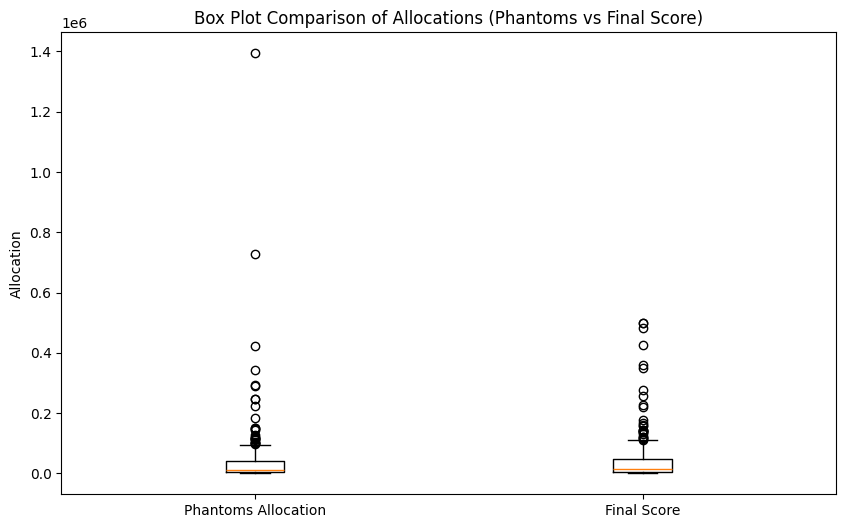

In [174]:
# Plot all projects in a simple bar plot for both voting rules
import matplotlib.pyplot as plt
df=merged_df
summary_stats = df[['phantoms_allocation', 'final_score']].describe()

# Create box plots for both voting rules to visualize the distributions
plt.figure(figsize=(10, 6))

# Box plot for phantoms_allocation and final_score
plt.boxplot([df['phantoms_allocation'], df['final_score']], labels=['Phantoms Allocation', 'Final Score'])

# Add labels and title
plt.title('Box Plot Comparison of Allocations (Phantoms vs Final Score)')
plt.ylabel('Allocation')

# Display the box plots
plt.show()


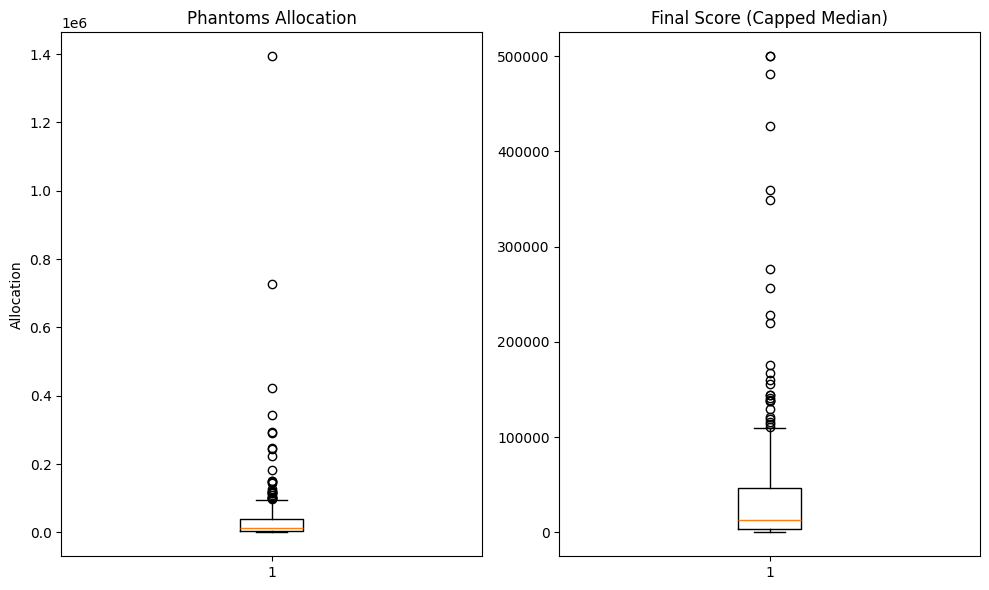

In [175]:
# Create separate box plots for Phantoms Allocation and Final Score

plt.figure(figsize=(10, 6))

# Subplot 1: Box plot for Phantoms Allocation
plt.subplot(1, 2, 1)
plt.boxplot(df['phantoms_allocation'])
plt.title('Phantoms Allocation')
plt.ylabel('Allocation')

# Subplot 2: Box plot for Final Score
plt.subplot(1, 2, 2)
plt.boxplot(df['final_score'])
plt.title('Final Score (Capped Median)')

# Adjust layout for clarity
plt.tight_layout()

# Display the separate box plots
plt.show()
